# **Risk Process and Fractional Brownian Motion**

# Introduction
In the report, two tasks will be solved and discussed. The first one concerns risk processes and various estimations of the probability of ruin. The second task involves the implementation of fractional Brownian motion.

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sb
from statsmodels import api
import pandas as pd
from numba import jit

# Part 1 - Risk Process

**Risk process** is a stochastic process
$$ R(t) = u + c(t) - \sum_{i=1}^{N(t)}{X_i}, \text{ } t\in [0, T], $$
where
- $u>0$ - initial capital,
- $c(t)$ - premium, i.e., revenue from selling policies,
- $N(t)$ - the number of claims until time $t$,
- $X_i$ - the size of the $i$-th claim, $X_i$-i.i.d. ($E|X_i| < \infty$).

A **classical risk process** $R(t)$ is a process for which:
- $N(t)$ is a Poisson process with intensity $\lambda>0$,
- $ c(t) = (1+\theta)\mu \lambda t $, where $\mu = EX_i$, $\theta$ - the parameter of premium rate.

#### **Data Loading**

We load the necessary data for the task using the pandas library, specifically the read_json command. Then, we extract from it the trajectory of the risk process $R(t)$, the time step $h$, the time horizon $T$, the initial capital $u$ (which is the value of $R(0)$) and the premium rate parameter $\theta$.

In [145]:
df = pd.read_json('data.json')
Rd = df['trajektoria']
h = df['h'][0]
T = df['T'][0]
theta = df['theta'][0]
t = np.arange(0, T+h, h)
u = Rd[0]

## **a)**

To fit the risk model to the trajectory from the data, we need to find the distribution of $X_i$ and estimate the intensity parameter $\lambda$ of the Poisson process $N(t)$.

We will start by determining realizations of random variables $X_i$ and $T_i$ (waiting times for the $i$-th event) from the obtained data.

The algorithm for their determination involves finding two consecutive realizations of $R(t)$, such that the first one is greater than the second, and their difference equals one realization of the random variable $X_i$. We determine $T_i$ at the same moment as we find the realization of $X_i$, by subtracting from the time of the current claim the time of occurrence of the previous one.

In [146]:
def find_Xi_Ti(R, T=T, h=h):
    t = np.arange(0, T+h, h)
    Xi = []
    Ti = []
    maximum = 0
    for i in range(len(R)):
        if R[i] < maximum:
            Xi.append(maximum-R[i])
            if len(Ti) == 0:
                Ti.append(t[i])
            else:
                Ti.append(t[i]-sum(Ti))
        maximum = R[i]
    return np.array(Xi), np.array(Ti)

In [147]:
X, Ti = find_Xi_Ti(Rd)

Next, we will demonstrate that $X_i \sim Pareto(x_0, \alpha)$ with density
$$ f(x) = \frac{\alpha x_0^{\alpha}}{x^{\alpha+1}}, \text{  } x \geq x_0>0, \alpha > 0 $$
and distribution function
$$ F(x) = 1 - \left( \frac{x_0}{x} \right)^\alpha. $$

In [148]:
def pareto_pdf(x, x0, alpha):
    return alpha * x0**alpha / (x**(alpha+1))

In [149]:
def pareto_cdf(x, x0, alpha):
    return 1 - (x0/x)**alpha

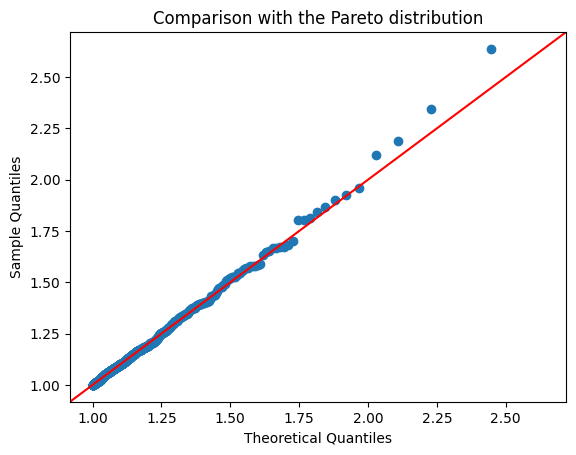

In [150]:
api.qqplot(X, stats.pareto, line='45', fit=True)
plt.title('Comparison with the Pareto distribution')
plt.show()

On the Q-Q plot, it is visible that theoretical quantiles and those determined from the sample have similar values.

For estimating distribution parameters, we will apply the maximum likelihood method. So, let's begin with a description of what it entails.

Let $X_1, X_2, ..., X_n$ be a simple random sample with an unknown parameter $\theta$ (similarly for multiple parameters). The maximum likelihood estimator is a value of the parameter $\theta$ that maximizes the likelihood function given the observed sample values $x_1, x_2, ..., x_n$:
$$ L(\theta) = \prod_{i=1}^{n} f(x_i, \theta), $$
where $f(x)$ is the density function of the random sample.

MLE estimators are asymptotically unbiased.

#### **Determination of the parameters $x_0$ and $\alpha$ of the Pareto distribution**

We will find the estimators of the parameters $x_0$ and $\alpha$ using the maximum likelihood method:
$$ L(x_0, \alpha) = \prod_{i=1}^{n}{f(x_i)} = \alpha^n x_0^{n\alpha}\prod_{i=1}^{n}{x_i^{-(\alpha+1)}}. $$
Next, we will take the natural logarithm of the likelihood function to simplify it (we can do this as it does not change the monotonicity of $L(x_0, \alpha)$)
$$ \ln{L(x_0, \alpha)} = n\ln{\alpha} + n\alpha \ln{x_0} - (n-1) \sum_{n=1}^n{\ln{x_i}}. $$
To find the maximum values of the parameters, we compute derivatives with respect to both variables. 
$$ \frac{d\ln{L(x_0, \alpha)}}{dx_0} = \frac{n\alpha}{x_0} > 0 $$
The derivative with respect to $x_0$ is always positive, so the best estimator will be
$$\hat{x}_0 = \min(X_1, X_2, ..., X_n).$$
Equating the derivative with respect to $\alpha$ to zero to find its maximum value
$$ \frac{d\ln{L(x_0, \alpha)}}{d\alpha} = \frac{n}{\alpha} + n\ln{x_0} - \sum_{n=1}^n{\ln{x_i}} = 0 $$
and obtaining the following estimator for $\alpha$
$$\hat{\alpha} = \frac{1}{\frac{1}{n}\sum_{n=1}^n{\ln{X_i}} - \ln{\hat{x}_0}}.$$

Estimation of the parameters $x_0$ and $\alpha$.

In [151]:
x0_estimator = lambda data: min(data)
alpha_estimator = lambda data: 1/(np.mean(np.log(data)) - np.log(min(data)))

In [152]:
x0 = x0_estimator(X)
alpha = alpha_estimator(X)

In [153]:
x0, alpha

(3.937642387320466, 9.718539670817004)

The estimated parameter values are: $x_0=3.937642387320466$, $\alpha=9.718539670817004$.

Next, we will conduct tests to determine whether $X_i$ originate from a Pareto distribution with these determined parameters. To achieve this, we will compare theoretical and empirical densities, distribution functions, means and variances.

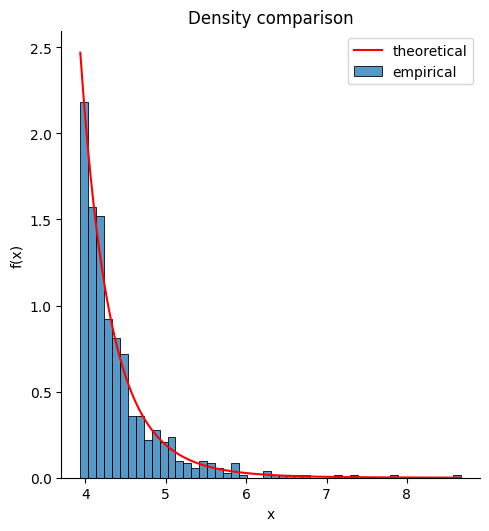

In [154]:
sb.displot(X, stat='density', label='empirical')
x = np.linspace(x0, max(X), 1000)
plt.plot(x, pareto_pdf(x, x0, alpha), 'r', label='theoretical')
plt.title('Density comparison')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

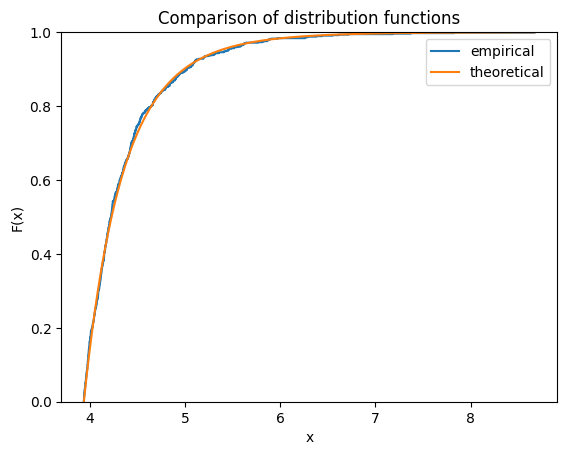

In [155]:
sb.ecdfplot(X, label='empirical')
plt.plot(x, pareto_cdf(x, x0, alpha), label='theoretical')
plt.title('Comparison of distribution functions')
plt.xlabel("x")
plt.ylabel("F(x)")
plt.legend()
plt.show()

In [156]:
np.mean(X), alpha*x0/(alpha-1)

(4.390889601243668, 4.389282516974366)

In [157]:
np.var(X), alpha*x0**2/((alpha-1)**2*(alpha-2))

(0.2760250791103403, 0.25683305516314947)

The empirical and theoretical plots of density and distribution function overlap. The expected values and variances also show little difference. Therefore, we can conclude that $X_i \sim Pareto(x_0=3.937642387320466, \alpha=9.718539670817004)$.

#### **Estimation of the parameter $\lambda$**

The next step in determining the risk process of the obtained trajectory is estimating the intensity $\lambda$ of the Poisson process $N(t)$.

We know that $T_i \sim Exp(\lambda)$ with density
$$ f_{T_i}(x) = \lambda e^{-\lambda x}, x \geq 0. $$
Let's then check if this agrees on the quantile plot.

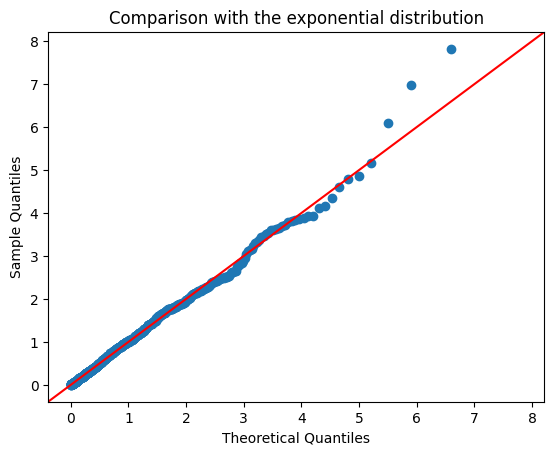

In [158]:
api.qqplot(Ti, stats.expon, line='45', fit=True)
plt.title('Comparison with the exponential distribution')
plt.show()

It is evident that the theoretical and data-obtained quantiles are close to each other. Now we can calculate the maximum likelihood estimator of the parameter $\lambda$
$$ L(\lambda) = \prod_{i=1}^{n}{f_{T_i}(x_i)} = \prod_{i=1}^{n}{\lambda e^{-\lambda x}} = \lambda^n e^{-\lambda \sum_{i=1}^{n}x_i}. $$
We apply the logarithm function to $L(\lambda)$ as before
$$ \ln{L(\lambda)} = n\ln{\lambda} - \lambda \sum_{i=1}^{n} x_i $$
and calculate its derivative, which we set to zero
$$ \frac{d\ln{L(\lambda)}}{d\lambda} = \frac{n}{\lambda} - \sum_{i=1}^{n} x_i = 0. $$
By solving this, we obtain the estimator
$$ \hat{\lambda} = \frac{1}{\frac{1}{n} \sum_{i=1}^{n} X_i}. $$

We estimate the parameter $\lambda$ and test whether $T_i$ originates from an exponential distribution with the determined $\lambda$.

In [159]:
lam_estimator = lambda data: 1/np.mean(data)

In [160]:
lam = lam_estimator(Ti)

In [161]:
lam

7.405541561712846

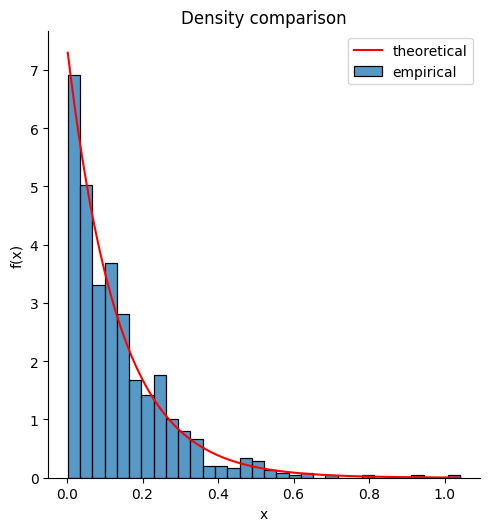

In [162]:
sb.displot(Ti, stat='density', label='empirical')
t = np.linspace(min(Ti), max(Ti), 1000)
plt.plot(t, lam*np.exp(-lam*t), 'r', label='theoretical')
plt.title('Density comparison')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

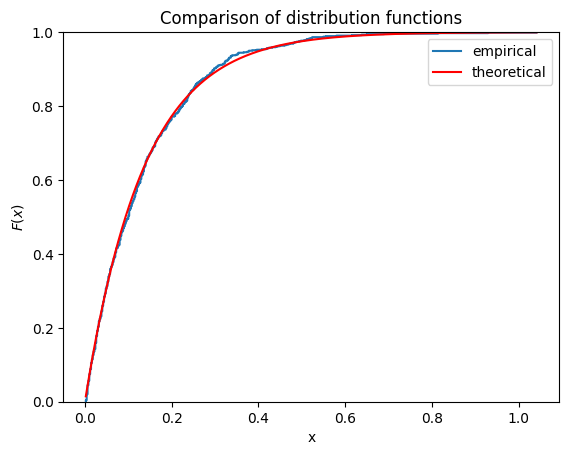

In [163]:
sb.ecdfplot(Ti, label="empirical")
plt.plot(t, 1-np.exp(-lam*t), 'r', label='theoretical')
plt.title('Comparison of distribution functions')
plt.xlabel("x")
plt.ylabel("$F(x)$")
plt.legend()
plt.show()

In [164]:
f'The theoretical expected value is: {1/lam}, mean of the data: {np.mean(Ti)}.'

'The theoretical expected value is: 0.13503401360544218, mean of the data: 0.13503401360544218.'

In [165]:
f'The theoretical variance is: {1/lam**2}, data variance: {np.var(Ti)}.'

'The theoretical variance is: 0.018234184830394743, data variance: 0.01743447911518346.'

The empirical and theoretical plots of density and distribution function are close to each other. The expected values and variances also show little difference. Therefore, we can conclude that $T_i \sim Exp(\lambda=7.405541561712846)$.

### **Risk Process**
Having determined the distribution of $X_i$ and the parameter value $\lambda$, we will now proceed to determine the risk process from which the trajectory in the data originates.

A **Poisson process** with intensity $\lambda>0$ is a counting process $N(t)$ that satisfies:
- $N(0)=0$,
- $N(t)$ has independent increments,
- $N(t)$ has stationary increments,
- $N(t) \sim Pois(\lambda t)$,
- $N(t)$ has cadlag trajectories.

**Algorithm** for generating one trajectory of $N(t)$ on the interval $[0, T]$:
1. Set $t=0$, $I=0$.
2. Generate $U \sim U(0,1)$.
3. Set $t = t - \frac{1}{\lambda} \ln{U}$. If $t>T$, stop.
4. Set $I=I+1$, $S(I)=t$.
5. Go back to step 2.

In [166]:
@jit()
def poisson_process(lam, T):
    I = [0]
    S = [0]
    t = 0
    while True:
        U = np.random.random()
        t = t - np.log(U)/lam
        if t > T:
            break
        I.append(I[-1]+1)
        S.append(t)
    return np.array(S), np.array(I)

**Generating a random variable $X_i$ from the Pareto distribution using the inverse transform method**:

The distribution function of the Pareto distribution $Pareto(x_0, \alpha)$: $F(x) = 1 - \left( \frac{x_0}{x} \right)^\alpha$ dla $x \geq x_0$.

We determine the inverse function $F^{-1}(y)$:
$$ y = F(x) \Leftrightarrow y = 1 - \left( \frac{x_0}{x} \right)^\alpha \Leftrightarrow x = \frac{x_0}{\sqrt[\alpha]{1-y}}. $$
So, $F^{-1}(y)=\frac{x_0}{\sqrt[\alpha]{1-y}}$. 

So, the random variable $X_i = \frac{x_0}{\sqrt[\alpha]{1-U}} \stackrel{d}{=} \frac{x_0}{\sqrt[\alpha]{U}}$, where $U \sim U(0,1)$.

In [167]:
@jit()
def pareto_variable(size, x0, alpha):
    return x0 / (np.random.random(size))**(1/alpha)

**Algorithm** for generating the trajectory of $R(t)$ on the interval $[0, T]$:
1. Generate $N(t)$ na $[0, T]$.
2. Generate $X_1, X_2, ..., X_{N(T)}$.
3. Set $ R(t) = u + (1+\theta)\mu \lambda t - \sum_{i=1}^{N(t)}{X_i} $, $t \in [0, T]$.

In [168]:
@jit()
def risk_process(T=T, u=u, theta=theta, lam=lam, x0=x0, alpha=alpha, h=h):
    tp, N = poisson_process(lam, T)
    X = pareto_variable(N[-1], x0, alpha)
    mu = alpha*x0/(alpha-1)
    c = lambda t: (1+theta)*mu*lam*t
    t = np.arange(0, T+h, h)
    n = len(t)
    R = np.zeros(n)
    for i in range(n):
        R[i] = u + c(t[i]) - sum(X[:N[tp<=t[i]][-1]+1])
    return t, R

**Expected value** of the classical risk process is given by
$$ E[R(t)] = u + \mu \lambda \theta t. $$
For this example, it is
$$ E[R(t)] = u + \frac{\alpha \cdot x_0}{\alpha-1} \lambda \theta t \approx 100 + 0.325 t. $$

In [169]:
mu = alpha*x0/(alpha-1)

Simulating 100 trajectories of the risk process and comparing it with the trajectory obtained from the data, as well as with the expected value of the process:

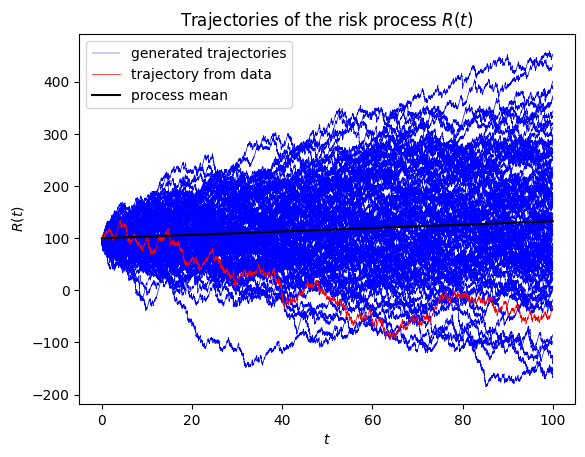

In [170]:
t, R = risk_process()
plt.step(t, R, 'blue', linewidth=0.3, where="post", label='generated trajectories')
for i in range(99):
    t, R = risk_process()
    plt.step(t, R, 'blue', linewidth=0.5, where="post")
plt.step(t, Rd, 'red', linewidth=0.5, where="post", label='trajectory from data')
plt.plot([0, T], [u, u+lam*theta*mu*T], 'black', label='process mean')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$R(t)$')
plt.title('Trajectories of the risk process $R(t)$')
plt.show()

From the plot, it's evident that the trajectories cluster around the expected value, and the trajectory from the data aligns well with those simulated. Therefore, we can conclude that it originates from the determined risk process.

## **b)**

**Ruins moment** is defined as the random variable of the following form
$$ \tau(u) = \inf{\{ t \geq 0 : R(t)<0 \}}. $$

**Probability of ruin within finite time T** is defined as
$$ \psi(u, T) = P(\tau(u) \leq T). $$

**Algorithm** for approximating $\psi(u, T)$:
1. Generate $N$ trajectories of the Poisson process $[0,T]$ $R^{(1)}(t)$, $R^{(2)}(t)$, ..., $R^{(N)}(t)$, $t \in [0, T]$.
2. Determine $ n = \#\{i \in \{ 1, 2, ..., N \}: \min_{t \in [0, T]}{R^{(i)}(t)<0} \} $.
3. Set $\psi(u, T) = \frac{n}{N} $.

To speed up the algorithm, generate trajectories only for $t$ where a claim of size $X_i$ occurs.

In [171]:
T1 = 100
T2 = 200

In [172]:
@jit()
def _risk_process(T=T, u=u, theta=theta, lam=lam, x0=x0, alpha=alpha):
    tp, N = poisson_process(lam, T)
    tp = tp[1:]
    X = pareto_variable(N[-1], x0, alpha)
    mu = alpha*x0/(alpha-1)
    c = lambda t: (1+theta)*mu*lam*t
    return u + c(tp) - np.cumsum(X)

In [173]:
@jit()
def finite_probability_of_ruin(N, T=T, u=u, theta=theta, lam=lam, x0=x0, alpha=alpha):
    return sum([1 if min(_risk_process(T, u, theta, lam, x0, alpha)) < 0 else 0 for _ in range(N)])/N

$T_1 = 100$

In [174]:
finite_probability_of_ruin(10**5, T1)

0.31705

So $ \psi(u, T_1) = \psi(100, 100) \approx 0.31507$.

$T_2 = 200$

In [175]:
finite_probability_of_ruin(10**5, T2)

0.4308

So $ \psi(u, T_2) = \psi(100, 200) \approx 0.42876$.

### Probability of ruin in infinite time
**Probability of ruin in infinite time** is defined as
$$ \psi(u) = P(\tau(u) < \infty). $$

**Pollaczek-Khinchine formula** (for determining the probability of ruin in infinite time)
$$ \psi(u) = \frac{\theta}{1 + \theta} \sum_{n=0}^{\infty}{(\frac{1}{1+\theta})^n} \cdot B_n(u), $$
where $B_n(u) = P(Y_1+Y_2+...+Y_n > u)$, $Y_i$ - i.i.d. random variables with density $f_{Y}(x) = \frac{P(X_i>x)}{\mu}$, $x>0$, $\mu=EX_i$.

**Algorithm** for approximating $\psi(u)$:
1. Set $I=0$.
2. For i=1:N
- Generate $K \sim Geom(\frac{\theta}{1+\theta})$.
- Generate $Y_1, Y_2, ..., Y_K$.
- If $Y_1 + Y_2 + ... + Y_K > u$, then $I=I+1$.
3. Set $\psi(u) = \frac{I}{N}$.

##### Determining the distribution of random variables $Y_i$

The random variables $Y_i$ have the density
$$  \begin{equation*}
f_Y (x) = \begin{cases}
        0 \text{, $x < 0$,}
        \\
        \frac{P(X_i > x)}{\mu} \text{, $x \geq 0$}
\end{cases}
= \begin{cases}
        0 \text{, $x < 0$,}
        \\
        \frac{1}{\mu} \text{, $0 \leq x < x_0$}
        \\
        \frac{1 - F(x)}{\mu} \text{, $x \geq x_0$}
\end{cases}
= \begin{cases}
        0 \text{, $x < 0$,}
        \\
        \frac{\alpha-1}{\alpha x_0} \text{, $0 \leq x < x_0$}
        \\
        \frac{\alpha-1}{\alpha x_0} \left(\frac{x_0}{x}\right)^\alpha \text{, $x \geq x_0$}
\end{cases}
\end{equation*} $$
and the distribution function
$$  \begin{equation*}
F_Y (x) = \int_{-\infty}^{x}{f_Y}(t)dt = \begin{cases}
        0 \text{, $x < 0$,}
        \\
        \frac{\alpha-1}{\alpha x_0}x \text{, $0 \leq x < x_0$}
        \\
        1 - \frac{1}{\alpha} \left(\frac{x_0}{x}\right)^{\alpha-1} \text{, $x \geq x_0$}
\end{cases}.
\end{equation*} $$

The expected value of $Y_i$:
$$ EY_i = \int_{\R}{xf_Y(x) dx} = \int_{0}^{x_0}{\frac{\alpha-1}{\alpha x_0} x dx} + \int_{x_0}^{\infty}{\frac{\alpha-1}{\alpha} \left( \frac{x_0}{x}\right)^{\alpha-1} dx} = \frac{\alpha-1}{\alpha(\alpha-2)}x_0. $$

The variance of $Y_i$:
$$ VarY_i = EX^2 - (EX)^2 = (\alpha-1) \left( \frac{1}{3(\alpha-3)} - \frac{\alpha-1}{4(\alpha-2)^2} \right) x_0^2, $$
becouse 
$$ EY_i^2 = \int_{\R}{x^2 f_Y(x) dx} = \frac{\alpha-1}{3(\alpha-3)} x_0^2. $$

**Generating random variables $Y_i$** using the inverse distribution method:

We determine the inverse function $F_{Y}^{-1}(y)$:
$$ \begin{equation*}
y = F_{Y}(x) \Leftrightarrow x = F^{-1}(y) = \begin{cases}
        0 \text{, $y < 0$,}
        \\
        \frac{\alpha x_0}{\alpha-1}y \text{, $0 \leq y < \frac{\alpha-1}{\alpha}$}
        \\
        \frac{x_0}{\sqrt[\alpha-1]{\alpha(1-y)}} \text{, $y \geq \frac{\alpha-1}{\alpha}$}
\end{cases}.
\end{equation*} $$

So, the random variable
$$Y_i = \begin{cases}
        \frac{\alpha x_0}{\alpha-1}U \text{, $0 \leq U < x_0$}
        \\
        \frac{x_0}{\sqrt[\alpha-1]{\alpha(1-U)}} \text{, $U \geq x_0$}
\end{cases},$$ 
where $U \sim U(0,1)$.

Tests for the random variable $Y_i$

In [176]:
@jit()
def Y_variable(size, x0, alpha):
    U = np.random.random(size)
    for i in range(size):
        if U[i] >= (alpha-1)/alpha:
            U[i] = x0/(alpha*(1-U[i]))**(1/(alpha-1))
        else:
            U[i] = alpha*x0/(alpha-1)*U[i]
    return U

In [177]:
Y = Y_variable(5000, x0, alpha)

In [178]:
def Y_pdf(x, alpha, x0):
    if x < 0:
        return 0
    elif 0 <= x < x0:
        return (alpha-1)/(alpha*x0)
    else:
        return (alpha-1)/alpha * x0**(alpha-1)/x**alpha
    
def Y_cdf(x, alpha, x0):
    if x < 0:
        return 0
    elif 0 <= x < x0:
        return (alpha-1)/(alpha*x0) * x
    else:
        return 1 - (x0/x)**(alpha-1)/alpha

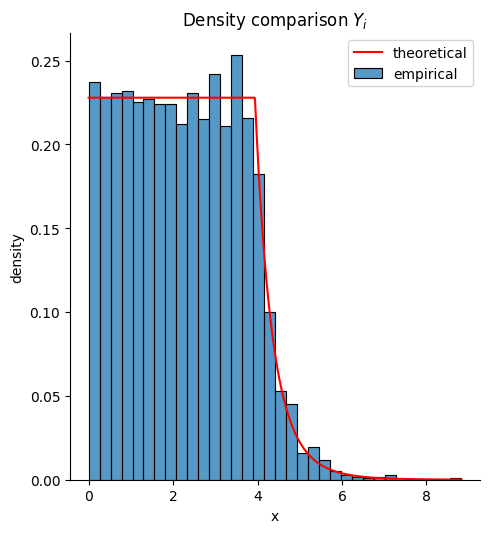

In [179]:
sb.displot(Y, stat='density', label='empirical')
x3 = np.linspace(0, max(Y), 1000)
plt.plot(x3, [Y_pdf(x, alpha, x0) for x in x3], 'r', label='theoretical')
plt.legend()
plt.title('Density comparison $Y_i$')
plt.xlabel('x')
plt.ylabel('density')
plt.show()

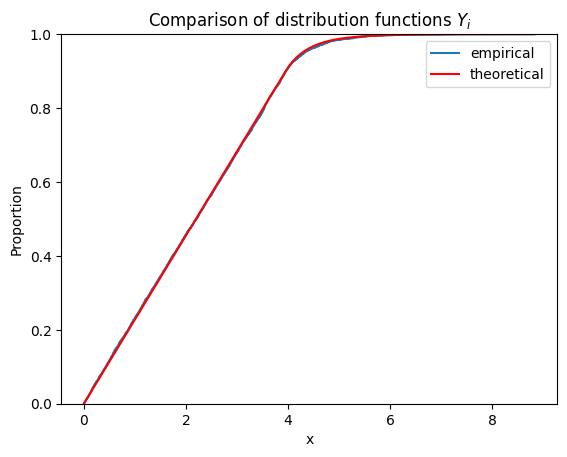

In [180]:
sb.ecdfplot(Y, label='empirical')
plt.plot(x3, [Y_cdf(x, alpha, x0) for x in x3], 'r', label='theoretical')
plt.legend()
plt.title('Comparison of distribution functions $Y_i$')
plt.xlabel('x')
plt.show()

In [181]:
f'The theoretical expected value is: {(alpha-1)*x0/(2*(alpha-2))}, mean of the data: {np.mean(Y)}.'

'The theoretical expected value is: 2.223898096497714, mean of the data: 2.2285111646169997.'

In [182]:
f'The theoretical variance is: {(alpha-1)*x0**2*(1/(3*(alpha-3))-(alpha-1)/(4*(alpha-2)**2))}, data variance: {np.var(Y)}.'

'The theoretical variance is: 1.7611512991278, data variance: 1.8107040535549934.'

The empirical and theoretical density and distribution function plots are close to each other. The expected values and variances also differ insignificantly. Therefore, the function Y_variable(size, x0, alpha) generates realizations of random variables $Y_i$.

#### The probability of ruin in infinite time

Generating a random variable $K$ o **rozkładzie geometrycznym** $Geo(p)$ (using the inverse distribution method: $p_i = p(1-p)^i, i=0,1,...$) using the inverse distribution method.

Therefore, 
$$ \sum_{i=0}^{j-1} p_i < U \leq \sum_{i=0}^{j} p_i \Leftrightarrow j < \frac{\ln{1-U}}{\ln{1-p}} \leq j+1 \Leftrightarrow 
j = \left\lfloor \frac{\ln{1-U}}{\ln{1-p}} \right\rfloor. $$
So,
$$ K = \left\lfloor \frac{\ln{1-U}}{\ln{1-p}} \right\rfloor \stackrel{d}{=} \left\lfloor \frac{\ln{U}}{\ln{1-p}} \right\rfloor. $$


In [183]:
@jit()
def geometric_distribution(p, n=1):
    return np.floor(np.log(np.random.random(n)) / np.log(1-p))

In [184]:
@jit()
def infinite_probability_of_ruin(N, x0=x0, alpha=alpha, u=u, theta=theta):
    counter = 0
    for _ in range(N):
        K = int(geometric_distribution(theta/(1+theta))[0])
        if sum(Y_variable(K, x0, alpha)) > u:
            counter += 1
    return counter/N

In [185]:
infinite_probability_of_ruin(10**5)

0.63758

So, $ \psi(u) = \psi(100) \approx 0.63$.

## **c)**

**Parisian ruin** occurs when the capital falls below 0 for at least $q$ time units.

We simulate the **probability of Parisian ruin $\psi(u, T, q)$** within a finite time $T$ similarly to the probability of ruin in the same time frame. Again, we initially check the times $t$ at which a new loss occurs, and if the value of $R(t) < 0$, we examine what happens in the subsequent steps. If the number of steps for which $R(t) < 0$ reaches $q$, then ruin occurs. We repeat this algorithm $N$ times, and the result is the ratio of the number of trajectories where ruin occurred to $N$.

In [186]:
@jit()
def _parisian_ruin(q, T=T, u=u, theta=theta, lam=lam, x0=x0, alpha=alpha, h=h):
    tp, N = poisson_process(lam, T)
    X = pareto_variable(N[-1], x0, alpha)
    mu = alpha*x0/(alpha-1)
    c = lambda t: (1+theta)*mu*lam*t
    R = u + c(tp[1:]) - np.cumsum(X)
    counter = 0
    r = 0
    for i in range(len(R)):
        r = R[i]
        t = tp[i+1]
        if r >= 0:
            counter = 0
        else:
            while t < tp[i+2]:
                if counter == q:
                    return 1
                r = u + c(t) - sum(X[:N[tp<=t][-1]+1])
                if r < 0:
                    counter += 1
                else:
                    counter = 0
                    break
                t += h
    return 0

In [187]:
def parisian_ruin(q, N, T=T, u=u, theta=theta, lam=lam, x0=x0, alpha=alpha, h=h):
    return sum([_parisian_ruin(q, T, u, theta, lam, x0, alpha, h) for _ in range(N)])/N

#### **The probability of ruin depending on q**

In [188]:
h0 = 0.1
T = 100
n = 30

In [189]:
q = np.arange(1, T*(1+1/n)/h0, T/h0/n, dtype='int32')

In [190]:
parisian_ruin_seq = np.array([parisian_ruin(i, 2*10**4, h=h0) for i in q])

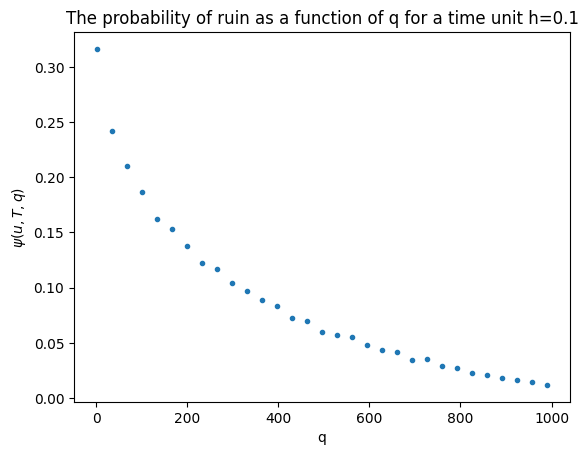

In [191]:
plt.plot(q, parisian_ruin_seq, '.')
plt.title(f'The probability of ruin as a function of q for a time unit h={h0}')
plt.ylabel('$\psi(u, T, q)$')
plt.xlabel('q')
plt.show()

In the graph of the probability of ruin as a function of $q$ (for a time step of $h=0.1$), it can be observed that with an increase in $q$, the probability of ruin decreases more rapidly than linearly.

#### **The impact of the value of $q$ on the initial capital $u$**

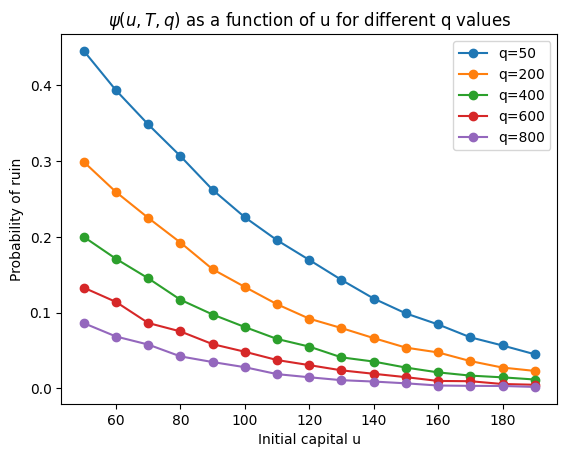

In [192]:
u0 = np.arange(50, 200, 10)
for q in [50, 200, 400, 600, 800]:
    ruina_u = np.array([parisian_ruin(q, 2*10**4, u=i, h=h0) for i in u0])
    plt.plot(u0, ruina_u, 'o-', label=f'q={q}')
plt.legend()
plt.title('$\psi(u, T, q)$ as a function of u for different q values')
plt.ylabel('Probability of ruin')
plt.xlabel('Initial capital u')
plt.show()

On the above graph, it's evident that the larger the value of $q$, the smaller the probability of ruin becomes. The same principle applies to the initial capital: the larger $u$ is, the smaller the probability of ruin. Therefore, it can be deduced that the larger $q$ we assume, the smaller the initial capital $u$ can be.

#### **Average time to reach ruin depending on q**
Simulating the **average time to ruin** (for a fixed $q$) for a time horizon $T$ is very similar to determining the probability of Parisian ruin. However, in this case, when ruin does not occur, we use recursion to simulate the next trajectory until ruin occurs, and then return the time of its occurrence. We repeat this process $N$ times, and the result is the average of the times.

In [193]:
@jit()
def pareto_variable(size, x0, alpha):
    return x0 / (np.random.random(size))**(1/alpha)

In [194]:
@jit()
def poisson_process(lam, T):
    I = [0]
    S = [0]
    t = 0
    while True:
        U = np.random.random()
        t = t - np.log(U)/lam
        if t > T:
            break
        I.append(I[-1]+1)
        S.append(t)
    return np.array(S), np.array(I)

In [195]:
@jit()
def _average_time_to_reach_ruin(q, T=T, u=u, theta=theta, lam=lam, x0=x0, alpha=alpha, h=h):
    tp, N = poisson_process(lam, T)
    X = pareto_variable(N[-1], x0, alpha)
    mu = alpha*x0/(alpha-1)
    c = lambda t: (1+theta)*mu*lam*t
    R = u + c(tp[1:]) - np.cumsum(X)
    counter = 0
    r = 0
    for i in range(len(R)):
        r = R[i]
        t = tp[i+1]
        if r >= 0:
            counter = 0
        else:
            while t < tp[i+2]:
                if counter == q:
                    return t
                r = u + c(t) - sum(X[:N[tp<=t][-1]+1])
                if r < 0:
                    counter += 1
                else:
                    counter = 0
                    break
                t += h
    return _average_time_to_reach_ruin(q, T, u, theta, lam, x0, alpha, h)

In [196]:
def average_time_to_reach_ruin(q, N, T=T, u=100, theta=theta, lam=lam, x0=x0, alpha=alpha, h=h):
    return np.mean([_average_time_to_reach_ruin(q, T, u, theta, lam, x0, alpha, h) for _ in range(N)])

In [197]:
q2 = np.arange(1, 700, 10)

In [198]:
average_time_seq = np.array([average_time_to_reach_ruin(i, 1000, h=h0) for i in q2])

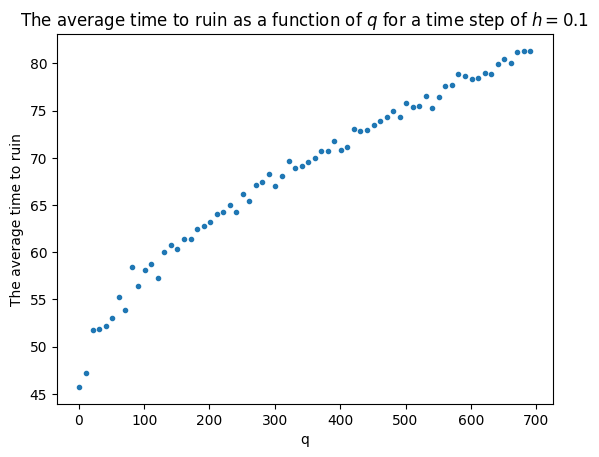

In [199]:
plt.plot(q2, average_time_seq, '.')
plt.title(f'The average time to ruin as a function of $q$ for a time step of $h={h0}$')
plt.xlabel('q')
plt.ylabel('The average time to ruin')
plt.show()

The above graph shows that when $q$ is greater, the average time to ruin is also greater.

# Part 2 - fractional Brownian motion

A stochastic process $X(t), t \geq 0$ is called a Gaussian process if every vector $(X(t_1), X(t_2), ... , X(t_n))$ has a Gaussian distribution.

Such a process is uniquely defined by the mean function $m(t) = EX(t)$ and the autocovariance function $c(s,t) = Cov(X(s), X(t))$.

**Brownian motion** refers to a Gaussian process $B(t), t \geq 0,$ with $m(t)=0$ and $c(s,t) = \mathrm{min}(s,t)$.

**Fractional Brownian motion** $B_H(t), t \geq 0, H \in (0,1)$, is a Gaussian process with mean $m(t)=EB_H(t)=0$ and autocovariance function $c(s,t) = Cov(B_H(t), B_H(s)) = E[B_H(t) B_H(s)] = \frac{\sigma^2}{2}(t^{2H}+s^{2H}-|t-s|^{2H})$ .

**Fractional Gaussian noise** is defined as
$$b_H(k) \overset{\mathrm{def}}{=} B_H(k+1)-B_H(k), \ k \in \N_0.$$

#### **Simulating trajectories of $B_H(t)$**
The **covariance matrix $\Gamma_N$** of the Gaussian vector $X = (X_1, X_2, ..., X_N)^T$ is defined as
$$ \Gamma_N = \begin{pmatrix}
1 & \gamma(1) & \ldots & \gamma(N-1) \\
\gamma(1) & 1 & \ldots & \gamma(N-2) \\
\vdots & \vdots & \ddots & \vdots \\
\gamma(N-1) & \gamma(N-2) & \ldots & 1 \\
\end{pmatrix}, $$
where $ \gamma(k) = EX_1X_{k+1} = \frac{1}{2} ((k+1)^{2H} + |k-1|^{2H} - 2k^{2H}) $, where $k \geq 0$.

From the Cholesky decomposition theorem (because $\Gamma_N$ is symmetric and positive definite), we know that there exists a lower triangular matrix $L$ that satisfies $\Gamma_N=LL^T$. **Nonzero elements of the matrix $L$** can be determined recursively using the formulas (for the following formulas $n\geq 2$):
- $ l_{11} = 1 $,
- $ l_{21} = \gamma(1) $,
- $ l_{22} = \sqrt{1 - \gamma^2(1)} $,
- $ l_{n+1,1} = \gamma(n) $,
- $ l_{n+1,j} = l_{jj}^{-1} ( \gamma(n+1-j) - \sum_{k=1}^{j-1}{l_{n+1,k} l_{jk}} ) $ dla $2 \leq j \leq n$,
- $ l_{n+1,n+1} = \sqrt{1 - \sum_{k=1}^{n}{l_{n+1,k}^{2}}} $.

**Algorithm** for generating trajectories $B_H(t)$:
1. Divide the interval $[0, T]$ into $N+1$ equal intervals $[t_{i-1}, t_i]$ such that $t_i - t_{i-1} = \frac{T}{N+1}$.
2. Generate $ Z = (Z_1, Z_2, ..., Z_N)^T$ such that $Z_i \sim N(0,1)$.
3. Generate the matrix $L$, as described above.
4. Set $ X = (X_1, X_2, ..., X_N)^T = L \cdot Z $.
5. Set $B_H(0)=0$, $B_H(k) = \sum_{i=0}^{k}{X_i}$, $1 \leq k \leq N+1$.
6. Set $B(t_i) = \left( \frac{T}{N+1} \right)^H B_H(i) $, $i=0, 1, ..., N+1$.

In [200]:
def find_cov(H, N):
    gamma = lambda k: ((k+1)**(2*H) + np.abs(k-1)**(2*H) -2*k**(2*H))/2
    cov = np.zeros((N, N))
    cov[[i for i in range(N)], [i for i in range(N)]] = 1
    for k in range(1, N):
        cov[[i for i in range(k, N)], [i for i in range(N-k)]] = gamma(k)
        cov[[i for i in range(N-k)], [i for i in range(k, N)]] = gamma(k)
    return cov

def find_L(H, N):
    gamma = lambda k: ((k+1)**(2*H) + np.abs(k-1)**(2*H) -2*k**(2*H))/2
    L = np.zeros((N, N))
    L[0,0] = 1
    L[1, 0] = gamma(1)
    L[1,1] = np.sqrt(1-gamma(1)**2)
    for n in range(2, N):
        L[n, 0] = gamma(n)
        for j in range(1, n):
            L[n, j] = 1/L[j,j] * (gamma(n-j) - sum(L[n, range(j)]*L[j, range(j)]))
        L[n,n] = np.sqrt(1-sum(L[n]**2))
    return L

def fractional_brownian_motion(H, T, N, L=False):
    B = np.zeros(N+1)
    try:
        if L == False:
            L = find_L(H, N)
    except ValueError:
        pass
    Z = np.random.normal(0, 1, N).transpose()
    X = np.matmul(L, Z).transpose()
    B[1:] = np.cumsum(X)
    B = (T/(N+1))**H * B
    return B


In [201]:
N = 1000
T = 100

Checking if the matrix $L$ has been implemented correctly by verifying the difference $\Gamma_N-LL^T$ for $N=5$.

In [202]:
Gamma_5 = find_cov(0.3, 5)
L_5 = find_L(0.3, 5)
np.matmul(L_5, L_5.transpose()) - Gamma_5

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.93889390e-18,  3.46944695e-18],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.77555756e-17, -6.93889390e-18],
       [ 0.00000000e+00,  6.93889390e-18, -2.77555756e-17,
         0.00000000e+00,  2.77555756e-17],
       [ 0.00000000e+00,  3.46944695e-18, -6.93889390e-18,
         2.77555756e-17,  0.00000000e+00]])

From the above matrix, it's evident that the largest differences are on the order of $10^{-17}$, indicating that the matrices are well-implemented.

#### **Generating 100 trajectories of $B_H(t)$ for a time horizon of $T=100$ and chosen $H$**

In [203]:
H1 = 0.2
H2 = 0.8
T = 100
N = 1000

#### 1. $H = 0.2$

In [204]:
L = find_L(H1, N)

In [205]:
t = np.linspace(0, T, N+1)

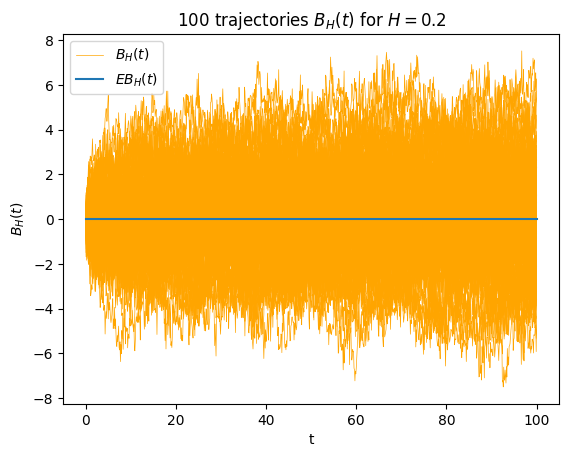

In [206]:
B1 = fractional_brownian_motion(H1, T, N, L)
plt.plot(t, B1, 'orange', linewidth=0.5, label='$B_H(t)$')
for i in range(99):
    B1 = fractional_brownian_motion(H1, T, N, L)
    plt.plot(t, B1, 'orange', linewidth=0.5)
plt.plot([0, T], [0, 0], label='$EB_H(t)$')
plt.legend()
plt.title(f'100 trajectories $B_H(t)$ for $H={H1}$')
plt.xlabel('t')
plt.ylabel('$B_H(t)$')
plt.show()

The trajectories appear to cluster around the mean of the process on the above plot.

#### 2. $H = 0.8$

In [207]:
L2 = find_L(H2, N)

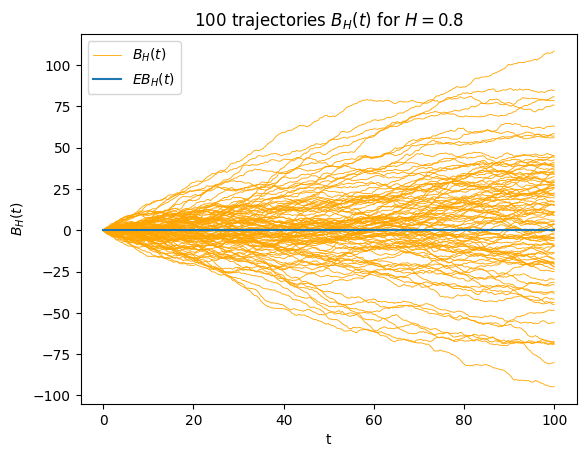

In [208]:
B2 = fractional_brownian_motion(H2, T, N, L2)
plt.plot(t, B2, 'orange', linewidth=0.6, label='$B_H(t)$')
for i in range(99):
    B2 = fractional_brownian_motion(H2, T, N, L2)
    plt.plot(t, B2, 'orange', linewidth=0.6)
plt.plot([0, T], [0, 0], label='$EB_H(t)$')
plt.legend()
plt.title(f'100 trajectories $B_H(t)$ for $H={H2}$')
plt.xlabel('t')
plt.ylabel('$B_H(t)$')
plt.show()

The trajectories appear to cluster around the mean of the process on the above plot.

#### **Quantile lines $q_p(t)$**

**Quantile lines** of the process $B_H(t)$ take the form $q_p(t)=t^H q_p$, where $q_p$ is the $p$-quantile of the $N(0, \sigma^2)$ distribution.

In [209]:
p1 = 0.05
p2 = 0.3
p3 = 0.7
p4 = 0.95

In [210]:
def theoretical_quantile_lines(p, t, H):
    result = np.zeros(len(t))
    result[1:] = t[1:]**H * stats.norm.ppf(p, loc=0, scale=t[1:]**H)
    return result

In [211]:
def empirical_quantile_lines(p, t, H, L, size):
    N = len(t)
    B_seq = np.array([fractional_brownian_motion(H, T, N-1, L) for _ in range(size)])
    B_seq = np.array([B_seq[:, i] for i in range(N)])
    return t**H * np.array([np.quantile(B, p) for B in B_seq])

#### 1. $H = 0.2$

In [212]:
q1_emp = empirical_quantile_lines(p1, t, H1, L, 1000)

In [213]:
q2_emp = empirical_quantile_lines(p2, t, H1, L, 1000)

In [214]:
q3_emp = empirical_quantile_lines(p3, t, H1, L, 1000)

In [215]:
q4_emp = empirical_quantile_lines(p4, t, H1, L, 1000)

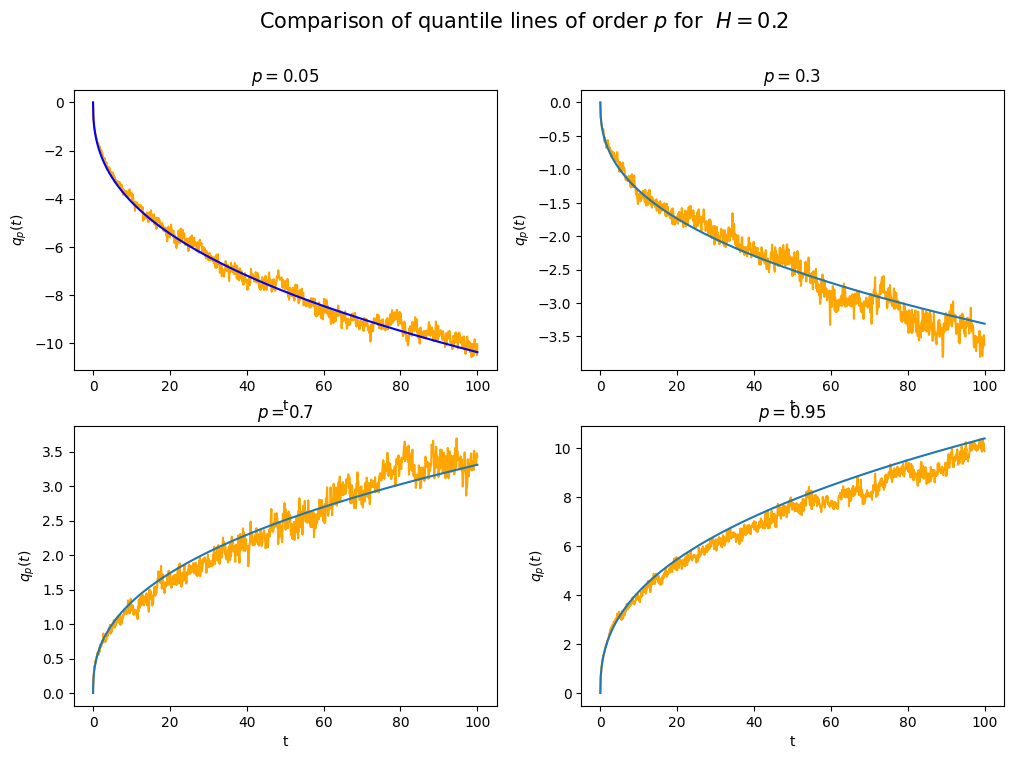

In [216]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(t, q1_emp, 'orange')
axs[0, 0].plot(t, theoretical_quantile_lines(p1, t, H1), 'blue')
axs[0, 0].set_title(f'$p={p1}$')

axs[0, 1].plot(t, q2_emp, 'orange')
axs[0, 1].plot(t, theoretical_quantile_lines(p2, t, H1))
axs[0, 1].set_title(f'$p={p2}$')

axs[1, 0].plot(t, q3_emp, 'orange')
axs[1, 0].plot(t, theoretical_quantile_lines(p3, t, H1))
axs[1, 0].set_title(f'$p={p3}$')

axs[1, 1].plot(t, q4_emp, 'orange')
axs[1, 1].plot(t, theoretical_quantile_lines(p4, t, H1))
axs[1, 1].set_title(f'$p={p4}$')

for ax in axs.flat:
    ax.set(xlabel='t', ylabel='$q_p(t)$')

fig.suptitle(f'Comparison of quantile lines of order $p$ for  $H={H1}$', fontsize=15)

fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

From the above plot, it's evident that the empirical quantile lines closely match the theoretical ones.

#### 2. $H = 0.8$

In [217]:
q1_emp2 = empirical_quantile_lines(p1, t, H2, L2, 1000)
q2_emp2 = empirical_quantile_lines(p2, t, H2, L2, 1000)
q3_emp2 = empirical_quantile_lines(p3, t, H2, L2, 1000)
q4_emp2 = empirical_quantile_lines(p4, t, H2, L2, 1000)

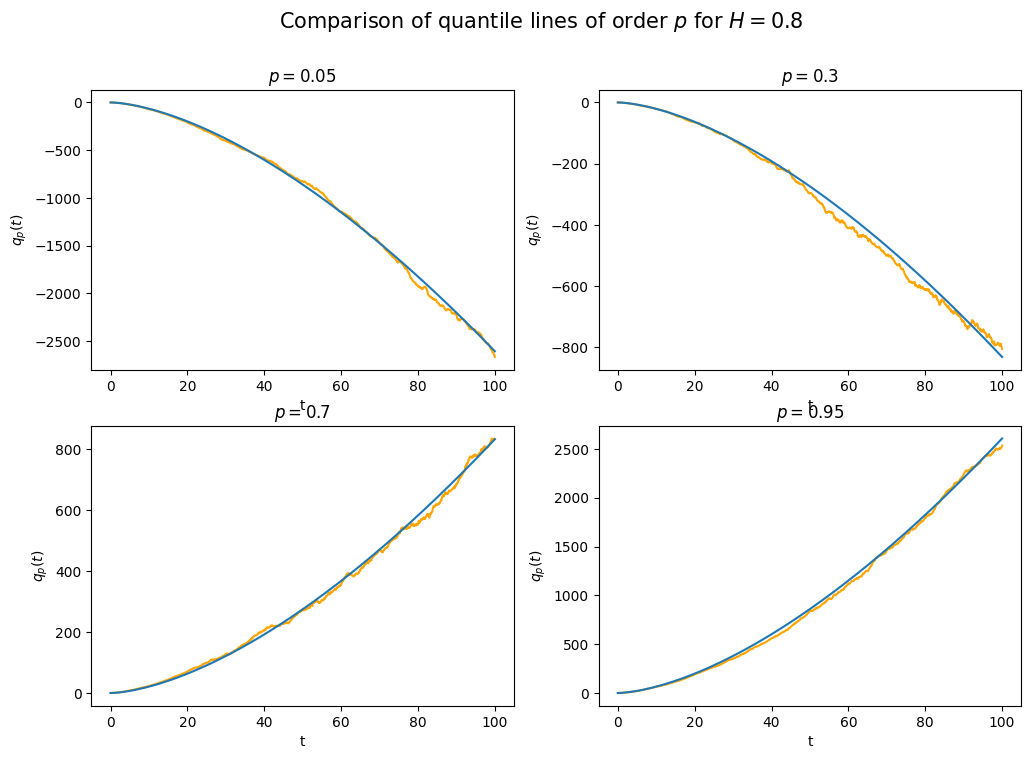

In [218]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(t, q1_emp2, 'orange')
axs[0, 0].plot(t, theoretical_quantile_lines(p1, t, H2))
axs[0, 0].set_title(f'$p={p1}$')

axs[0, 1].plot(t, q2_emp2, 'orange')
axs[0, 1].plot(t, theoretical_quantile_lines(p2, t, H2))
axs[0, 1].set_title(f'$p={p2}$')

axs[1, 0].plot(t, q3_emp2, 'orange')
axs[1, 0].plot(t, theoretical_quantile_lines(p3, t, H2))
axs[1, 0].set_title(f'$p={p3}$')

axs[1, 1].plot(t, q4_emp2, 'orange')
axs[1, 1].plot(t, theoretical_quantile_lines(p4, t, H2))
axs[1, 1].set_title(f'$p={p4}$')

for ax in axs.flat:
    ax.set(xlabel='t', ylabel='$q_p(t)$')

fig.suptitle(f'Comparison of quantile lines of order $p$ for $H={H2}$', fontsize=15)

fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

From the above plot, it's evident that the empirical quantile lines closely match the theoretical ones.

# Summary

The report covers topics related to risk processes and fractional Brownian motion. The first part involved fitting a classical risk process model to the data and calculating ruin probabilities in finite and infinite time. The graphs also illustrate how the probability of Parisian ruin changes with $q$ (the number of consecutive time units in which the capital is below 0), the impact of $q$ on the initial capital, and how the average ruin time varies with $q$. In the second part, a generator for fractional Brownian motion trajectories was implemented and tested by comparing theoretical and empirical quantile lines.